In [28]:
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from white_box.data import (
    chunk_and_tokenize,
    compute_nats_to_bpb_ratio,
    silence_datasets_messages
)

name = "EleutherAI/pythia-160m-deduped"

model = AutoModelForCausalLM.from_pretrained(
    name, torch_dtype="auto"
).cuda()

In [29]:
tokenizer = AutoTokenizer.from_pretrained(name)

dataset = Dataset.from_json("/mnt/ssd-1/nora/lens-test.jsonl")
assert isinstance(dataset, Dataset)
silence_datasets_messages()

processed = chunk_and_tokenize(dataset, tokenizer)
nats_to_bpb = compute_nats_to_bpb_ratio(dataset, processed)

Using custom data configuration default-17b5822e070b1eaf
/mnt/ssd-1/nora/miniconda3/lib/python3.10/site-packages/datasets/builder.py:712: FutureWarning:

'use_auth_token' was deprecated in version 2.7.1 and will be removed in 3.0.0. Pass `use_auth_token` to the initializer/`load_dataset_builder` instead.

Found cached dataset json (/home/mchorse/.cache/huggingface/datasets/json/default-17b5822e070b1eaf/0.0.0)


In [1]:
from pathlib import Path
import torch as th


def get_bases_and_kls(infix: str):
    bases = [
        th.load(path, map_location="cpu")
        for path in sorted(
            Path(f"/mnt/ssd-1/nora/tuned-lenses/{infix}bases/").glob("layer_*.pt"),
            key=lambda x: int(x.stem.split("_")[1])
        )
    ]
    kls = th.load(
        f"/mnt/ssd-1/nora/tuned-lenses/{infix}bases/kls.pt",
        map_location="cpu"
    )
    return bases, kls

neo125m_ll_bases, neo125m_ll_kls = get_bases_and_kls("gpt-neo/125M/extra-layer/ll-")
neo125m_tl_bases, neo125m_tl_kls = get_bases_and_kls("gpt-neo/125M/extra-layer/")
# 
# neo1_3b_ll_bases, neo1_3b_ll_kls = get_bases_and_kls("gpt-neo/1.3B/extra-layer/ll-")
# neo1_3b_tl_bases, neo1_3b_tl_kls = get_bases_and_kls("gpt-neo/1.3B/extra-layer/")

pythia_ll_bases, pythia_ll_kls = get_bases_and_kls("pythia/160m-deduped/ll-")
pythia_tl_bases, pythia_tl_kls = get_bases_and_kls("pythia/160m-deduped/affine/")

pythia410m_ll_bases, pythia410m_ll_kls = get_bases_and_kls("pythia/410m-deduped/ll-")
pythia410m_tl_bases, pythia410m_tl_kls_zero = get_bases_and_kls("pythia/410m-deduped/affine/")

pythia410m_tl_kls = th.load(
    f"/mnt/ssd-1/nora/tuned-lenses/pythia/410m-deduped/affine/bases/mean-ablation-eval/kls.pt",
    map_location="cpu"
)

In [31]:
from white_box import TunedLens

lens = TunedLens.load(
    "/mnt/ssd-1/nora/tuned-lenses/pythia/160m-deduped/affine",
    map_location="cuda:0"
)

TunedLens.load: ignoring config key 'mlp_hidden_sizes'
TunedLens.load: ignoring config key 'identity_init'
TunedLens.load: ignoring config key 'sublayers'
TunedLens.load: ignoring config key 'shared_mlp_hidden_sizes'
TunedLens.load: ignoring config key 'dropout'
TunedLens.load: ignoring config key 'rank'


In [32]:
from dataclasses import dataclass
from tqdm.auto import trange
from transformers import PreTrainedModel
from typing import Callable, Literal, Optional
from white_box.causal import ablate_subspace, CausalBasis
from white_box.nn import Decoder, TunedLens
from white_box.stats import aitchison_similarity, kl_divergence
from white_box.utils import pytree_map
import torch as th
import warnings


@dataclass
class InterventionResult:
    loss_diffs: th.Tensor
    response_sizes: th.Tensor
    stimulus_alignments: th.Tensor
    stimulus_angles: th.Tensor
    stimulus_sizes: th.Tensor
    stimulus_norms: th.Tensor
    surprisals: th.Tensor


@th.autocast("cuda", enabled=th.cuda.is_available())
@th.no_grad()
def cbe_alignment(
    model: PreTrainedModel,
    token_ids: th.Tensor,
    bases: list[CausalBasis],
    *,
    decoder: Optional[Decoder] = None,
    divergence: Callable[[th.Tensor, th.Tensor], th.Tensor] = kl_divergence,
    lens: Optional[TunedLens] = None,
    mode: Literal["mean", "resample"] = "resample",
    seed: int = 42,
):
    """Estimate the expected causal effect of resampling residuals on model outputs."""
    assert token_ids.ndim == 2
    (B, S), L = token_ids.shape, model.config.num_hidden_layers
    if S // B > 128:
        warnings.warn("We recommend a larger batch size for better performance.")

    device = model.device
    token_ids = token_ids.to(device)

    rng = th.Generator(device=device)
    rng.manual_seed(seed)

    # First do a clean forward pass on all the data. We save the final layer logits,
    # as well as the keys and values to speed up inference when we do interventions.
    control = model(token_ids, output_hidden_states=True, use_cache=True)
    c_inputs = control["hidden_states"]
    c_resids = [h_ - h for h, h_ in zip(c_inputs[:-1], c_inputs[1:])]

    def transform(x, i, j):
        if lens:
            return lens.transform_hidden(x, i + 1)
        else:
            return x

    decoder = decoder or Decoder(model)
    c_outputs = c_inputs[1:-1]  # Drop input embeddings and final layer
    assert len(c_outputs) == L - 1

    if lens:
        assert len(lens) == L
        lens = lens.to(device)

    result = InterventionResult(
        loss_diffs=th.zeros(B, S, L - 1, device=device),
        response_sizes=th.zeros(B, S, L - 1, device=device),
        stimulus_alignments=th.zeros(B, S, L - 1, device=device),
        stimulus_sizes=th.zeros(B, S, L - 1, device=device),
        stimulus_angles=th.zeros(B, S, L - 1, device=device),
        stimulus_norms=th.zeros(B, S, L - 1, device=device),
        surprisals=th.zeros(B, S, L - 1, device=device),
    )

    for token_idx in trange(1, S, desc="Applying", unit="token"):
        left_ctx = pytree_map(lambda x: x[..., :token_idx, :], control.past_key_values)
        new_tokens = token_ids[:, token_idx, None]

        # Sequentially intervene on each layer
        for i, c_out in enumerate(c_outputs):
            c_out = c_out[:, token_idx]
            c_logits_i = decoder(transform(c_out, i, token_idx))

            with ablate_subspace(
                model, bases[i].vectors[:, :10].to(device).float(), i, mode="resample"
            ):
                treated = model(
                    new_tokens, output_hidden_states=True, past_key_values=left_ctx
                )

            # Aitchison difference between the treated and control logits
            treated_out = treated.hidden_states[i + 1].squeeze(1)
            treated_logits_i = decoder(transform(treated_out, i, token_idx))
            stimulus = th.log_softmax(treated_logits_i - c_logits_i, dim=-1)
            result.stimulus_sizes[:, token_idx, i] = divergence(
                c_logits_i, treated_logits_i
            )

            # Record the response from the final layer
            c_logits_f = control.logits[:, token_idx]
            treated_logits_f = treated.logits.squeeze(1)
            result.surprisals[:, token_idx, i] = divergence(
                treated_logits_f, treated_logits_i
            )
            if token_idx < S - 1:
                treated_loss = th.nn.functional.cross_entropy(
                    treated_logits_f, token_ids[:, token_idx + 1], reduction="none"
                )
                control_loss = th.nn.functional.cross_entropy(
                    c_logits_f, token_ids[:, token_idx + 1], reduction="none"
                )
                result.loss_diffs[:, token_idx, i] = treated_loss - control_loss

            weights = control.logits[:, token_idx].softmax(-1)

            # Aitchison difference
            response = th.log_softmax(treated_logits_f - c_logits_f, dim=-1)
            result.response_sizes[:, token_idx, i] = divergence(
                c_logits_f, treated_logits_f
            )
            result.stimulus_alignments[:, token_idx, i] = aitchison_similarity(
                stimulus, response, weight=weights
            )

    return result

In [33]:
results_160m_tl = [
    cbe_alignment(
        model,
        processed[i * 8 : (i + 1) * 8]["input_ids"].cuda(),
        pythia_tl_bases,
        lens=lens,
    )
    for i in range(8)
]

/tmp/ipykernel_2037099/4088154686.py:41: UserWarning:

We recommend a larger batch size for better performance.



Applying:   0%|          | 0/2047 [00:00<?, ?token/s]

Applying:   0%|          | 0/2047 [00:00<?, ?token/s]

Applying:   0%|          | 0/2047 [00:00<?, ?token/s]

Applying:   0%|          | 0/2047 [00:00<?, ?token/s]

Applying:   0%|          | 0/2047 [00:00<?, ?token/s]

Applying:   0%|          | 0/2047 [00:00<?, ?token/s]

Applying:   0%|          | 0/2047 [00:00<?, ?token/s]

Applying:   0%|          | 0/2047 [00:00<?, ?token/s]

In [34]:
results_160m_ll = [
    cbe_alignment(
        model,
        processed[i * 8 : (i + 1) * 8]["input_ids"].cuda(),
        pythia_ll_bases,
    )
    for i in range(8)
]

/tmp/ipykernel_2037099/4088154686.py:41: UserWarning:

We recommend a larger batch size for better performance.



Applying:   0%|          | 0/2047 [00:00<?, ?token/s]

Applying:   0%|          | 0/2047 [00:00<?, ?token/s]

Applying:   0%|          | 0/2047 [00:00<?, ?token/s]

Applying:   0%|          | 0/2047 [00:00<?, ?token/s]

Applying:   0%|          | 0/2047 [00:00<?, ?token/s]

Applying:   0%|          | 0/2047 [00:00<?, ?token/s]

Applying:   0%|          | 0/2047 [00:00<?, ?token/s]

Applying:   0%|          | 0/2047 [00:00<?, ?token/s]

In [37]:
ll_alignments = th.cat([r.stimulus_alignments for r in results_160m_ll], dim=0)
ll_alignments.mean(0).mean(0)

tensor([0.0574, 0.1049, 0.1213, 0.1579, 0.1670, 0.2219, 0.2999, 0.3018, 0.4051,
        0.4820, 0.6888], device='cuda:0')

In [38]:
tl_alignments = th.cat([r.stimulus_alignments for r in results_160m_tl], dim=0)
tl_alignments.mean(0).mean(0)

tensor([0.0782, 0.1694, 0.1955, 0.2085, 0.2467, 0.3064, 0.3785, 0.4242, 0.4918,
        0.6207, 0.7252], device='cuda:0')

In [39]:
import plotly.graph_objects as go

TEXT_WIDTH = 6.75 * 96


fig = go.Figure([
    go.Scatter(
        mode="lines+markers",
        name="Logit lens",
        y=ll_alignments.mean(0).mean(0).cpu().numpy(),
    ),
    go.Scatter(
        mode="lines+markers",
        name="Tuned lens",
        y=tl_alignments.mean(0).mean(0).cpu().numpy()
    ),
]).update_annotations(
    font=dict(color="black", size=20),
).update_layout(
    font=dict(color="black", size=16),
    # height=TEXT_WIDTH,
    width=TEXT_WIDTH,
    legend=dict(
        x=0.75,
        y=0.025,
    ),
    margin_l=70,
    margin_r=30,
    margin_t=50,
    margin_b=70,
    # title=f"Stimulus-response alignment (Pythia 160M)",
    xaxis_title="Layer",
    yaxis=dict(
        title="Aitchison similarity",
        range=[0, 0.8],
    ),
)
fig

In [42]:
fig.write_image(
    "/mnt/ssd-1/nora/sra-160m.pdf",
)

In [41]:
th.save(ll_alignments, "/mnt/ssd-1/nora/ll_sra-pythia-160m.pt")
th.save(tl_alignments, "/mnt/ssd-1/nora/tl_sra-pythia-160m.pt")

In [24]:
from plotly.subplots import make_subplots
from white_box.stats import spearmanr
import numpy as np
import plotly.graph_objects as go
import statsmodels.api as sm


TEXT_WIDTH = 6.75 * 96
titles = [f"Layer {i}" for i in range(0, 23)]
titles[0] = "Embeddings"

master = make_subplots(
    cols=4, rows=6,
    horizontal_spacing=0.05,
    vertical_spacing=0.03,
    subplot_titles=titles,
    x_title="Influence on lens (bits)",
    y_title="Influence on model (bits)",
)

for i in range(6):
    for j in range(4):
        layer = (i * 4 + j)
        if layer >= 23:
            continue

        master.add_trace(
            go.Scatter(
                marker=dict(opacity=0.25),
                mode="markers",
                name=f"Layer {layer}",
                x=pythia410m_tl_bases[layer].energies,
                y=pythia410m_tl_kls[layer],
            ),
            row=i + 1,
            col=j + 1,
        )
        # LOWESS trendline
        master.add_trace(
            go.Scatter(
                line=dict(color="black"),
                mode="lines",
                name=f"Layer {layer} trend",
                x=pythia410m_tl_bases[layer].energies,
                y=sm.nonparametric.lowess(
                    pythia410m_tl_kls[layer],
                    pythia410m_tl_bases[layer].energies,
                    return_sorted=False,
                )
            ),
            row=i + 1,
            col=j + 1,
        )
        master.add_annotation(
            dict(
                font=dict(color="black", size=16),
                showarrow=False,
                text=f"ρ = {spearmanr(pythia410m_tl_bases[layer].energies, pythia410m_tl_kls[layer]):.2f}",
                x=-4.5,
                xanchor="center",
                xref="paper",
                y=0.5,
                yanchor="bottom",
                yref="paper",
            ),
            row=i + 1,
            col=j + 1,
        )


master.update_layout(
    height=TEXT_WIDTH * 2.75,
    margin_l=70,
    margin_r=30,
    margin_t=30,
    margin_b=70,
    showlegend=False,
    # title="Causal fidelity in Pythia 410M",
    width=TEXT_WIDTH * 2,
).update_xaxes(
    range=[-6, 1.5],
    type="log",
).update_yaxes(
    range=[-3.1, 1],
    type="log",
)

In [25]:
master.write_image(
    "/mnt/ssd-1/nora/appendix-causal-fidelity.pdf",
)

In [38]:
import plotly.express as px


TEXT_WIDTH = 6.75 * 96
num_layers = len(pythia410m_tl_bases) + 1
mid_layer = 3 * (num_layers // 4)

fig = px.scatter(
    opacity=0.25,
    trendline="lowess",
    trendline_color_override="black",
    x=pythia410m_tl_bases[mid_layer].energies,
    y=pythia410m_tl_kls[mid_layer],
).update_annotations(
    font=dict(color="black", size=20),
).update_layout(
    font=dict(color="black", size=16),
    # height=TEXT_WIDTH,
    width=TEXT_WIDTH,
    margin_l=70,
    margin_r=30,
    margin_t=30,
    margin_b=70,
    # title=f"Causal fidelity in Pythia 410M (Layer {mid_layer} of {num_layers})",
).update_xaxes(
    # range=[-4, 0.25],
    title="Influence on lens (bits)",
    type="log"
).update_yaxes(
    title="Influence on model (bits)",
    type="log",
).add_annotation(
    dict(
        font=dict(color="black", size=20),
        showarrow=False,
        text=f"ρ = {spearmanr(pythia410m_tl_bases[mid_layer].energies, pythia410m_tl_kls[mid_layer]):.2f}",
        x=0.15,
        xanchor="center",
        xref="paper",
        y=0.85,
        yanchor="bottom",
        yref="paper",
    ),
)
fig

In [39]:
fig.write_image(
    "/mnt/ssd-1/nora/causal-fidelity-410m.pdf",
)

In [18]:
import numpy as np

np.polyfit(
    pythia_tl_bases[-1].energies.log(),
    pythia_tl_kls[-1].log(),
    2
)

array([ 0.06524206,  1.27308708, -0.55768121])

In [75]:
def effective_rank(B):
    probs = B / th.sum(B, dim=-1, keepdim=True)
    entropy = -th.sum(probs * th.log(probs), dim=-1)
    return entropy.exp()

In [209]:
from plotly.subplots import make_subplots
import math
import plotly.graph_objects as go

def get_trace(bases, kls, tuned: bool, **kwargs):
    return go.Scatter(
        x=list(range(1, len(bases) + 1)),
        y=[i_divergence(b.energies[:50].sqrt(), kl[:50].sqrt()) for b, kl in zip(bases, kls)],
        marker_color="blue" if tuned else "red",
        mode="lines+markers",
        name="Tuned lens" if tuned else "Logit lens",
        **kwargs
    )

master = make_subplots(
    cols=3,
    horizontal_spacing=0.05,
    shared_yaxes=True,
    subplot_titles=["GPT-Neo 125M", "GPT-Neo 1.3B", "Pythia 125M"],
    x_title="Layer",
    y_title="Generalized KL",
).add_traces(rows=1, cols=1, data=[
    get_trace(neo125m_ll_bases, neo125m_ll_kls, tuned=False, showlegend=False),
    get_trace(neo125m_tl_bases, neo125m_tl_kls, tuned=True, showlegend=False),
]).add_traces(rows=1, cols=2, data=[
    get_trace(neo1_3b_ll_bases, neo1_3b_ll_kls, tuned=False, showlegend=False),
    get_trace(neo1_3b_tl_bases, neo1_3b_tl_kls, tuned=True, showlegend=False),
]).add_traces(rows=1, cols=3, data=[
    get_trace(pythia_ll_bases, pythia_ll_kls, tuned=False),
    get_trace(pythia_tl_bases, pythia_tl_kls, tuned=True),
]).update_layout(
    legend=dict(
        x=0.875,
    ),
    title="Causal divergence across depth"
).update_annotations(
    font=dict(size=18),
).update_layout(
    font=dict(size=18),
    height=400,
    width=1200,
)
master

In [113]:
import plotly.graph_objects as go

fig = go.Figure([
    go.Scatter(
        x=list(range(1, 24)),
        y=[effective_rank(b.energies.sqrt()) for b in ll_bases],
        mode="lines+markers",
        name="Logit lens"
    ),
    go.Scatter(
        x=list(range(1, 24)),
        y=[effective_rank(b.energies.sqrt()) for b in tl_bases],
        mode="lines+markers",
        name="Tuned lens"
    ),
]).update_layout(
    height=500,
    width=700,
    legend=dict(
        title_text="Probe",
        x=0.8,
    ),
    title="Effective causal rank of probes (GPT Neo 1.3B)",
    xaxis_dtick=2,
    xaxis_title="Layer",
    # yaxis_range=[0, 55],
    yaxis_title="Effective num. features"
)
fig

In [10]:
from tqdm.auto import tqdm
from typing import Literal
from white_box.causal import ablate_subspace, CausalBasis, remove_subspace
from white_box.model_surgery import get_transformer_layers


@th.autocast("cuda", enabled=th.cuda.is_available())
@th.no_grad()
def eval_directions_tl(
    model: th.nn.Module,
    lens: TunedLens,
    bases: list[CausalBasis],
    tokens: th.Tensor,
    mode: Literal["mean", "resample"] = "mean",
    ll: bool = False
):
    hiddens = model(tokens, output_hidden_states=True).hidden_states[1:-1]

    layer_kls = []
    for i, basis in enumerate(tqdm(bases)):
        kls = th.zeros_like(basis.energies)
        losses = th.zeros_like(basis.energies)

        h = hiddens[i]
        logits = lens(h, i) if not ll else lens.to_logits(h)
        log_p = logits.log_softmax(-1)
        p = log_p.exp()

        for j, v in enumerate(basis.vectors.T):
            # with ablate_subspace(model, v, layer_index=i, mode=mode, orthonormal=True):
            h_ = remove_subspace(h, v, orthonormal=True, mode=mode)
            treated_logits = lens(h_, i) if not ll else lens.to_logits(h_)
            log_q = treated_logits.log_softmax(-1)

            kls[j] = th.sum(p * (log_p - log_q), dim=-1).mean()

        layer_kls.append(kls)

    return layer_kls

In [53]:
import torch as th

raw = th.load("/mnt/ssd-1/nora/tuned-lenses/pythia/12b-deduped/affine/downstream/injection/mnli.pt")
raw['metrics'][-1]

{'acc': 0.30588475684511646}

In [33]:
from tqdm.auto import tqdm
from typing import Literal
from tuned_lens.causal import ablate_subspace, CausalBasis

from tuned_lens.model_surgery import get_transformer_layers


@th.autocast("cuda", enabled=th.cuda.is_available())
@th.no_grad()
def eval_directions(
    model: th.nn.Module,
    bases: list[CausalBasis],
    tokens: th.Tensor,
    mode: Literal["mean", "resample"] = "mean",
):
    _, layers = get_transformer_layers(model)

    outputs = model(tokens, labels=tokens)
    base_loss = outputs.loss.item()

    log_p = outputs.logits.log_softmax(-1)
    p = log_p.exp()

    layer_kls = []
    layer_losses = []
    for i, basis in enumerate(tqdm(bases)):
        kls = th.zeros_like(basis.energies)
        losses = th.zeros_like(basis.energies)

        for j, v in enumerate(basis.vectors.T):
            with ablate_subspace(model, v, layer_index=i, mode=mode, orthonormal=True):
                outputs = model(tokens, labels=tokens)

                log_q = outputs.logits.log_softmax(-1)
                kls[j] = th.sum(p * (log_p - log_q), dim=-1).mean()
                losses[j] = outputs.loss.item()

        layer_kls.append(kls)
        layer_losses.append(losses)

    return base_loss, layer_kls, layer_losses

In [6]:
tokens = pythia_data[:8]["input_ids"].cuda()

In [7]:
tl_random_kls = eval_directions_tl(
    pythia, lens, [
        CausalBasis(b.energies[:50].cuda(), th.nn.init.orthogonal_(th.empty_like(b.vectors[:, :50].cuda())))
        for b in pythia_ll_bases
    ], tokens
)

  0%|          | 0/11 [00:00<?, ?it/s]

In [11]:
ll_random_kls = eval_directions_tl(
    pythia, lens, [
        CausalBasis(b.energies[:50].cuda(), th.nn.init.orthogonal_(th.empty_like(b.vectors[:, :50].cuda())))
        for b in pythia_ll_bases
    ], tokens, ll=True
)

  0%|          | 0/11 [00:00<?, ?it/s]

In [15]:
[k.mean() * nats_to_bpb for k in ll_random_kls][5]

tensor(0.0013, device='cuda:0')

In [16]:
[k.mean() * nats_to_bpb for k in tl_random_kls][5]

tensor(0.0005, device='cuda:0')

In [34]:
base, random_kls, random_losses = eval_directions(
    pythia, [
        CausalBasis(b.energies[:50].cuda(), th.nn.init.orthogonal_(th.empty_like(b.vectors[:, :50].cuda())))
        for b in pythia_ll_bases
    ], tokens
)

  0%|          | 0/11 [00:00<?, ?it/s]

(0.0, 4.0)

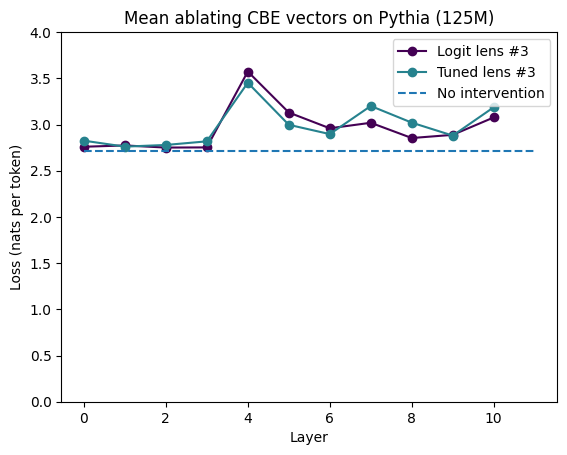

In [77]:
import matplotlib.pyplot as plt
import plotly.express as px

i = 2
plt.plot(
    [float(x[i]) for x in ll_mean_losses],
    c=px.colors.sequential.Viridis[0],
    label=f"Logit lens #{i + 1}",
    marker='o'
)

plt.plot(
    [float(x[i]) for x in mean_losses],
    c=px.colors.sequential.Viridis[4],
    label=f"Tuned lens #{i + 1}",
    marker='o'
)
# plt.plot([float(x) for x in ll_losses], label="Logit lens", marker='o')
# plt.plot([float(x) for x in gaussian_losses], label="Random directions", marker='o')

plt.hlines(
    base, 0, len(resample_losses), label="No intervention", linestyles="dashed"
)
plt.legend()
plt.title("Mean ablating CBE vectors on Pythia (125M)")
plt.xlabel("Layer")
plt.ylabel("Loss (nats per token)")
plt.ylim(0, 4)

In [8]:
tl_bases = extract_causal_bases(lens.float(), [x.float() for x in hiddens], 5)

  0%|          | 0/60 [00:00<?, ?it/s]

basis.energies=tensor([0.4445, 0.2650, 0.2371, 0.2009, 0.1159], device='cuda:0')
basis.energies=tensor([1.3165, 1.0208, 0.8240, 0.3534, 0.3243], device='cuda:0')
basis.energies=tensor([1.2251, 0.8647, 0.7177, 0.4760, 0.3298], device='cuda:0')
basis.energies=tensor([1.1975, 0.7813, 0.7424, 0.3395, 0.2331], device='cuda:0')
basis.energies=tensor([1.0132, 0.7200, 0.6749, 0.3026, 0.2915], device='cuda:0')
basis.energies=tensor([1.2330, 0.8009, 0.7124, 0.5854, 0.2865], device='cuda:0')
basis.energies=tensor([1.1286, 0.8225, 0.6973, 0.4152, 0.2663], device='cuda:0')
basis.energies=tensor([0.8816, 0.8303, 0.7254, 0.4936, 0.4292], device='cuda:0')
basis.energies=tensor([1.3715, 1.3278, 0.7315, 0.5420, 0.4441], device='cuda:0')
basis.energies=tensor([1.6791, 0.9830, 0.6107, 0.5387, 0.2101], device='cuda:0')
basis.energies=tensor([1.7197, 0.8418, 0.5676, 0.5374, 0.1858], device='cuda:0')
basis.energies=tensor([1.5420, 0.8037, 0.4757, 0.4007, 0.2492], device='cuda:0')
